## Titanic: Machine Learning from Disaster
A Kaggle competition
More data at: https://www.kaggle.com/c/titanic

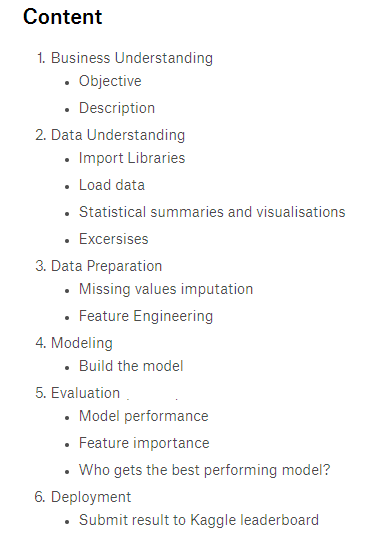

## Data Understanding
Import Libraries
Setup helper Functions
Load data

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.cross_validation import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# Setup helper Functions

def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

In [8]:
# Load data

# get titanic & test csv files as a DataFrame
train = pd.read_csv("input/train.csv")
test    = pd.read_csv("input/test.csv")

full = train.append( test , ignore_index = True )
titanic = full[ :891 ]

del train , test

print ('Datasets:' , 'full:' , full.shape , 'titanic:' , titanic.shape)

Datasets: full: (1309, 12) titanic: (891, 12)


## Statistical summaries and visualisations

In [14]:
# Run the code to see the variables, then read the variable description below to understand them.
titanic.head(10)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736


In [15]:
# a look at some key information about the variables
titanic.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,0.381594,446.000000,2.308642,0.523008,0.383838
std,14.526497,49.693429,0.806057,257.353842,0.836071,1.102743,0.486592
min,0.420000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20.125000,7.910400,0.000000,223.500000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,446.000000,3.000000,0.000000,0.000000
75%,38.000000,31.000000,0.000000,668.500000,3.000000,1.000000,1.000000
max,80.000000,512.329200,6.000000,891.000000,3.000000,8.000000,1.000000


In [71]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
Age            714 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
Fare           891 non-null float64
Name           891 non-null object
Parch          891 non-null int64
PassengerId    891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null object
SibSp          891 non-null int64
Survived       891 non-null float64
Ticket         891 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 83.6+ KB


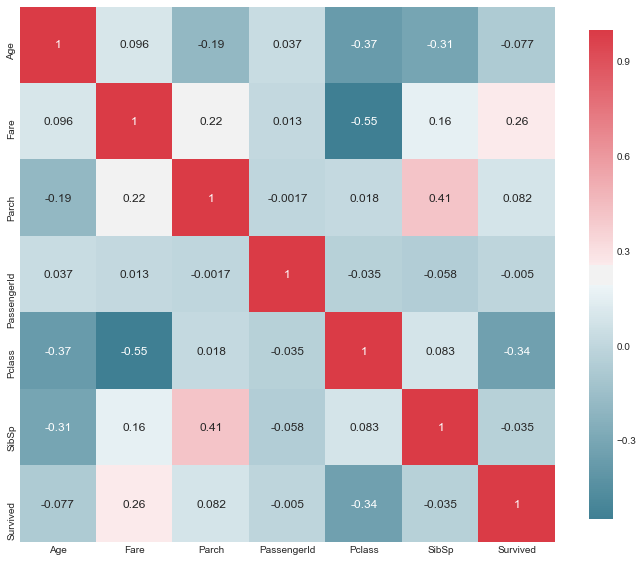

In [16]:
# A heat map of correlation may give us a understanding of which variables are important
plot_correlation_map( titanic )

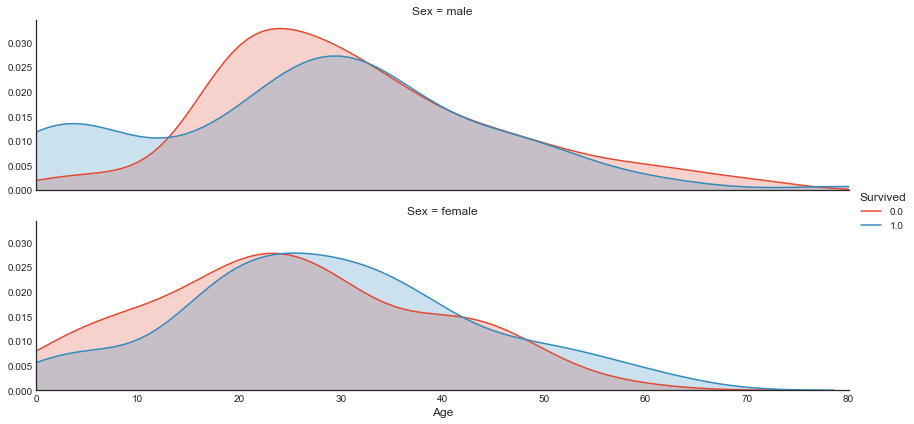

In [17]:
# explore the relationship between the features and survival of passengers
# Plot distributions of Age of passangers who survived or did not survive
plot_distribution( titanic , var = 'Age' , target = 'Survived' , row = 'Sex' )

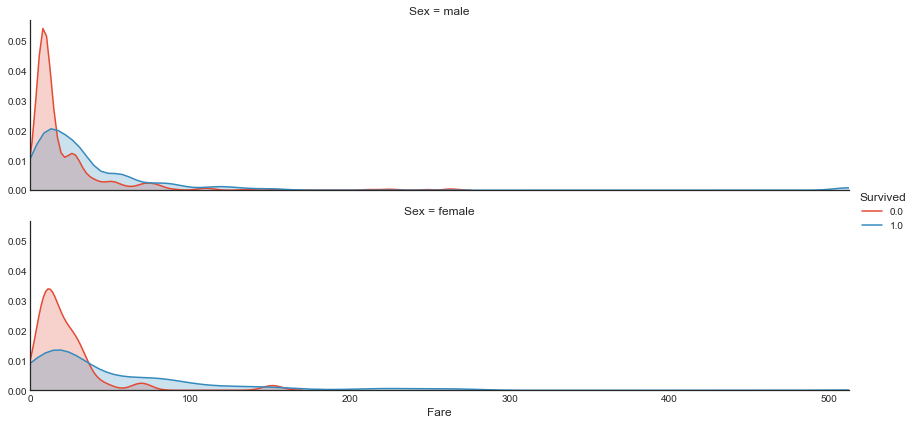

In [19]:
# explore the relationship between the features and survival of passengers
# Plot distributions of Age of passangers who survived or did not survive
plot_distribution( titanic , var = 'Fare' , target = 'Survived' , row = 'Sex' )

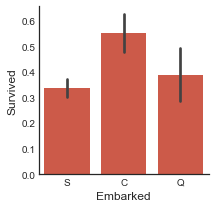

In [20]:
# Plot survival rate by Embarked
#C = Cherbourg
#Q = Queenstown
#S = Southampton
plot_categories( titanic , cat = 'Embarked' , target = 'Survived' )


The distribution of numerical feature values across the samples helps us determine, among other early insights, how representative is the training dataset of the actual problem domain:

* Total samples are 891 or 40% of the actual number of passengers on board the Titanic (2,224).
* Survived is a categorical feature with 0 or 1 values.
* Around 38% samples survived representative of the actual survival rate at 32%.
* Most passengers (> 75%) did not travel with parents or children.
* Nearly 30% of the passengers had siblings and/or spouse aboard.
* Fares varied significantly with few passengers (<1%) paying as high as $512.
* Few elderly passengers (<1%) within age range 65-80.


The distribution of categorical features:

* Names are unique across the dataset (count=unique=891)
* Sex variable as two possible values with 65% male (top=male, freq=577/count=891).
* Cabin values have several dupicates across samples. Alternatively several passengers shared a cabin.
* Embarked takes three possible values. S port used by most passengers (top=S)
* Ticket feature has high ratio (22%) of duplicate values (unique=681).

Assumtions based on data analysis

We arrive at following assumptions based on data analysis done so far. We may validate these assumptions further before taking appropriate actions.

Correlating.

We want to know how well does each feature correlate with Survival. We want to do this early in our project and match these quick correlations with modelled correlations later in the project.

Completing.

We may want to complete Age feature as it is definitely correlated to survival.
We may want to complete the Embarked feature as it may also correlate with survival or another important feature.
Correcting.

Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.
Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.
PassengerId may be dropped from training dataset as it does not contribute to survival.
Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.
Creating.

We may want to create a new feature called Family based on Parch and SibSp to get total count of family members on board.
We may want to engineer the Name feature to extract Title as a new feature.
We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature.
We may also want to create a Fare range feature if it helps our analysis.
Classifying.

We may also add to our assumptions based on the problem description noted earlier.

Women (Sex=female) were more likely to have survived.
Children (Age<?) were more likely to have survived.
The upper-class passengers (Pclass=1) were more likely to have survived.

## Data Preparation

In [25]:
# Categorical variables need to be transformed to numeric variables

# Transform Sex into binary values 0 and 1
sex = pd.Series( np.where( full.Sex == 'male' , 1 , 0 ) , name = 'Sex' )

# Create a new variable for every unique value of Embarked
embarked = pd.get_dummies( full.Embarked , prefix='Embarked' )
embarked.head()


,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [26]:

# Create a new variable for every unique value of Embarked
pclass = pd.get_dummies( full.Pclass , prefix='Pclass' )
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [27]:
# Fill missing values in variables
# machine learning alghorims require all variables to have values in order to use it for training the model. The simplest method is to fill missing values with the average of the variable across all observations in the training set.
# Create dataset
imputed = pd.DataFrame()

# Fill missing values of Age with the average of Age (mean)
imputed[ 'Age' ] = full.Age.fillna( full.Age.mean() )

# Fill missing values of Fare with the average of Fare (mean)
imputed[ 'Fare' ] = full.Fare.fillna( full.Fare.mean() )

imputed.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


In [29]:
# Extract titles from passenger names
# Titles reflect social status and may predict survival probability
title = pd.DataFrame()
# we extract the title from each name
title[ 'Title' ] = full[ 'Name' ].map( lambda name: name.split( ',' )[1].split( '.' )[0].strip() )

# a map of more aggregated titles
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }

# we map each title
title[ 'Title' ] = title.Title.map( Title_Dictionary )
title = pd.get_dummies( title.Title )
#title = pd.concat( [ title , titles_dummies ] , axis = 1 )

title.head(10)

,Master,Miss,Mr,Mrs,Officer,Royalty
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0
5,0,0,1,0,0,0
6,0,0,1,0,0,0
7,1,0,0,0,0,0
8,0,0,0,1,0,0
9,0,0,0,1,0,0


In [33]:
# Extract Cabin category information from the Cabin number
cabin = pd.DataFrame()

# replacing missing cabins with U (for Uknown)
cabin[ 'Cabin' ] = full.Cabin.fillna( 'U' )

# mapping each Cabin value with the cabin letter
cabin[ 'Cabin' ] = cabin[ 'Cabin' ].map( lambda c : c[0] )

# dummy encoding ...
cabin = pd.get_dummies( cabin['Cabin'] , prefix = 'Cabin' )

cabin.head()

C85
C


,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1


In [35]:
# Extract ticket class from ticket number
# a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket( ticket ):
    ticket = ticket.replace( '.' , '' )
    ticket = ticket.replace( '/' , '' )
    ticket = ticket.split()
    ticket = map( lambda t : t.strip() , ticket )
    ticket = list(filter( lambda t : not t.isdigit() , ticket ))
    if len( ticket ) > 0:
        return ticket[0]
    else: 
        return 'XXX'

ticket = pd.DataFrame()

# Extracting dummy variables from tickets:
ticket[ 'Ticket' ] = full[ 'Ticket' ].map( cleanTicket )
ticket = pd.get_dummies( ticket[ 'Ticket' ] , prefix = 'Ticket' )

ticket.shape
ticket.head(10)

,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [36]:
# Create family size and category for family size
# The two variables Parch and SibSp are used to create the famiy size variable
family = pd.DataFrame()

# introducing a new feature : the size of families (including the passenger)
family[ 'FamilySize' ] = full[ 'Parch' ] + full[ 'SibSp' ] + 1

# introducing other features based on the family size
family[ 'Family_Single' ] = family[ 'FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
family[ 'Family_Small' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
family[ 'Family_Large' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 5 <= s else 0 )

family.head()

,FamilySize,Family_Single,Family_Small,Family_Large
0,2,0,1,0
1,2,0,1,0
2,1,1,0,0
3,2,0,1,0
4,1,1,0,0


In [37]:
# Assemble final datasets for modelling
full_X = pd.concat( [ imputed , embarked , pclass , sex , family , cabin , ticket ] , axis=1 )
full_X.head()

,Age,Fare,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Sex,FamilySize,...,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,22.0,7.2500,0,0,1,0,0,1,1,2,...,0,0,0,0,0,0,0,0,0,0
1,38.0,71.2833,1,0,0,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
2,26.0,7.9250,0,0,1,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
3,35.0,53.1000,0,0,1,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1
4,35.0,8.0500,0,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1


In [38]:
# Create datasets - seperate the data into training and test datasets.
# Create all datasets that are necessary to train, validate and test models

train_valid_X = full_X[ 0:891 ]
train_valid_y = titanic.Survived
test_X = full_X[ 891: ]
train_X , valid_X , train_y , valid_y = train_test_split( train_valid_X , train_valid_y , train_size = .7 )

print (full_X.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape , test_X.shape)


(1309, 59) (623, 59) (268, 59) (623,) (268,) (418, 59)


0.99036918138


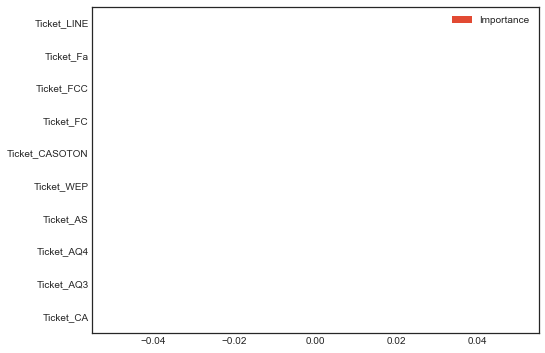

In [42]:
# Feature importance
plot_variable_importance(train_X, train_y)

## Modeling and Evaluation


In [68]:
model = RandomForestClassifier(n_estimators=100)
model.fit( train_X , train_y )
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

0.99036918138 0.779850746269


In [54]:
model = SVC()
model.fit( train_X , train_y )
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

0.772070626003 0.735074626866


In [67]:
model = GradientBoostingClassifier()
model.fit( train_X , train_y )
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))
#plot_model_var_imp(model, train_X, train_y)

0.905296950241 0.809701492537


In [65]:
model = KNeighborsClassifier(n_neighbors = 3)
model.fit( train_X , train_y )
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

0.821829855538 0.694029850746


In [63]:
model = GaussianNB()
model.fit( train_X , train_y )
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

0.475120385233 0.462686567164


In [61]:
#Logistic Regression is a useful model to run early in the workflow. 
#Logistic regression measures the relationship between the categorical dependent variable (feature) and one or more independent variables (features) by estimating probabilities using a logistic function, which is the cumulative logistic distribution
model = LogisticRegression()
model.fit( train_X , train_y )
print (model.score( train_X , train_y ) , model.score( valid_X , valid_y ))

0.829855537721 0.813432835821


## Deployment

In [69]:
test_Y = model.predict( test_X )
passenger_id = full[891:].PassengerId
test = pd.DataFrame( { 'PassengerId': passenger_id , 'Survived': test_Y } )
test.shape
test.head()
test.to_csv( 'titanic_pred.csv' , index = False )